# Project Overview

We are working with a fintech company to conduct an A/B test evaluating the impact of email campaigns on user account activity. The study targets 480,000 unfunded users in the treatment group, segmented into 12 subgroups of 40,000 users each based on prior account activity levels. Within each subgroup, users are further randomized to receive emails at different frequencies—either daily or twice a week. The goal is to assess how email frequency influences key user behaviors, including account linking, funding rates, and subsequent trading activity.

# Set up & Data import

In [3]:
import pandas as pd
import numpy as np
import datetime
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# email title
PO_number_list = ['ml_funding_enables_investing','ml_investing_starts_here','ml_explore_the_app_investing',
                  'ml_funding_faq','ml_user_clustering_emails_fracs','ml_funding_is_safe','ml_picking_an_investment', 
                  'ml_investing_101','ml_diversified_portfolio','ml_explore_the_app_list']

In [5]:
# segment characteristics
df1 = pd.read_csv('data/sample_segment_groups.csv')
df1.head()

,Unnamed: 0,group_id,approved_within6M_flag,link_flag,recent_activity_flag(20days),5day_trade_flag,user_uuid,group_name
0,0,0,False,False,False,False,4418550,ML_unfund_exp_control
1,1,1,False,False,True,False,314921,20D_Act
2,2,2,False,False,True,True,409786,20D_Act-5D_Act
3,3,3,False,True,False,False,941341,link
4,4,4,False,True,True,False,102541,link-20D_Act


In [6]:
# randomized email order
df2 = pd.read_csv('data/sample_uuid_email_order.csv')
df2.head()

,user_uuid,group_id,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9
0,id_2623238174270264636,0,ML_unfund_exp_control_D,5,7,3,4,8,9,0,1,6,2
1,id_14752263936159847779,0,ML_unfund_exp_control_D,3,1,6,0,5,9,4,8,7,2
2,id_3723259155072282145,0,ML_unfund_exp_control_D,8,7,3,6,1,4,2,9,0,5
3,id_9433964625840258739,0,ML_unfund_exp_control_D,1,8,0,6,5,7,4,9,3,2
4,id_17251718038176858460,0,ML_unfund_exp_control_D,6,1,8,0,7,3,5,2,9,4


In [7]:
# email response, raw
df3 = pd.read_csv('data/email_events.csv')
df3.head()

,stitch_email_events.category,stitch_email_events.dt_date,user_uuid,event,reason,stitch_email_events.count_events
0,"[""ml_picking_an_investment"",""post-office""]",2020-12-30,id_13999943483500367320,open,NaN,1
1,"[""ml_explore_the_app_investing"",""post-office""]",2020-12-30,id_3965698071238241409,open,NaN,1
2,"[""ml_picking_an_investment"",""post-office""]",2020-12-30,id_9648414115970654735,open,NaN,1
3,"[""ml_investing_starts_here"",""post-office""]",2020-12-30,id_8951454012305223869,open,NaN,1
4,"[""ml_investing_101"",""post-office""]",2020-12-30,id_8180145303883056882,open,NaN,2


In [8]:
# email response, summary
df4 = pd.read_csv('data/user_events.csv')
df4.head()

,user_uuid,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,...,approved_at,first_funded_at,first_linked_bank_account_at,5d_trading_avg_event_count,2d_non_trading_avg_event_count,20d_trading_avg_event_count,8d_non_trading_avg_event_count,1d_trading_avg_event_count,1d_non_trading_avg_event_count,num_received_email
0,id_2623238174270264636,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2020-01-14 16:31:59.295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,id_14752263936159847779,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,...,2019-01-29 16:22:26.866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
2,id_3723259155072282145,ML_unfund_exp_control_D,delivered,delivered,open,open,open,delivered,delivered,delivered,...,2019-02-01 00:01:48.853,2020-12-04 20:41:55.146,2020-12-04 20:41:37.842,53.0,NaN,171.0,NaN,NaN,NaN,6
3,id_9433964625840258739,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,...,2020-03-17 21:02:43.906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
4,id_17251718038176858460,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2019-12-30 18:23:15.726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


# 1. Email response

In [10]:
def report(df, cols):
    res = pd.DataFrame() # initialize an empty df to store the results
    
    for col in cols:
        # compute the summary for each col
        res[col] = df[col].value_counts()
    return res

In [11]:
df4_cols = ['ml_funding_enables_investing',
       'ml_investing_starts_here', 'ml_explore_the_app_investing',
       'ml_funding_faq', 'ml_user_clustering_emails_fracs',
       'ml_funding_is_safe', 'ml_picking_an_investment', 'ml_investing_101',
       'ml_diversified_portfolio', 'ml_explore_the_app_list']
res = report(df4, df4_cols).transpose()

In [12]:
res['total']=res.sum(axis=1)
res

ml_funding_enables_investing,delivered,open,unsubscribe,spamreport,total
ml_funding_enables_investing,346555,73024,112,23,419714
ml_investing_starts_here,345059,73455,99,27,418640
ml_explore_the_app_investing,345988,72784,98,17,418887
ml_funding_faq,309886,108794,89,22,418791
ml_user_clustering_emails_fracs,341874,76385,119,26,418404
ml_funding_is_safe,344931,74214,99,15,419259
ml_picking_an_investment,343862,74827,110,20,418819
ml_investing_101,344580,73746,115,26,418467
ml_diversified_portfolio,346372,72569,120,26,419087
ml_explore_the_app_list,343783,74365,115,25,418288


In [13]:
res['open_rate'] = res['open']/res['total']
res['unsubscribe_rate'] = res['unsubscribe']/res['total']
res['spamreport_rate'] = res['spamreport']/res['total']

In [14]:
res.sort_values(by=["open_rate", "unsubscribe_rate","spamreport_rate"], ascending=[0,1,1]).round(4)

ml_funding_enables_investing,delivered,open,unsubscribe,spamreport,total,open_rate,unsubscribe_rate,spamreport_rate
ml_funding_faq,309886,108794,89,22,418791,0.2598,0.0002,0.0001
ml_user_clustering_emails_fracs,341874,76385,119,26,418404,0.1826,0.0003,0.0001
ml_picking_an_investment,343862,74827,110,20,418819,0.1787,0.0003,0.0000
ml_explore_the_app_list,343783,74365,115,25,418288,0.1778,0.0003,0.0001
ml_funding_is_safe,344931,74214,99,15,419259,0.1770,0.0002,0.0000
ml_investing_101,344580,73746,115,26,418467,0.1762,0.0003,0.0001
ml_investing_starts_here,345059,73455,99,27,418640,0.1755,0.0002,0.0001
ml_funding_enables_investing,346555,73024,112,23,419714,0.1740,0.0003,0.0001
ml_explore_the_app_investing,345988,72784,98,17,418887,0.1738,0.0002,0.0000
ml_diversified_portfolio,346372,72569,120,26,419087,0.1732,0.0003,0.0001


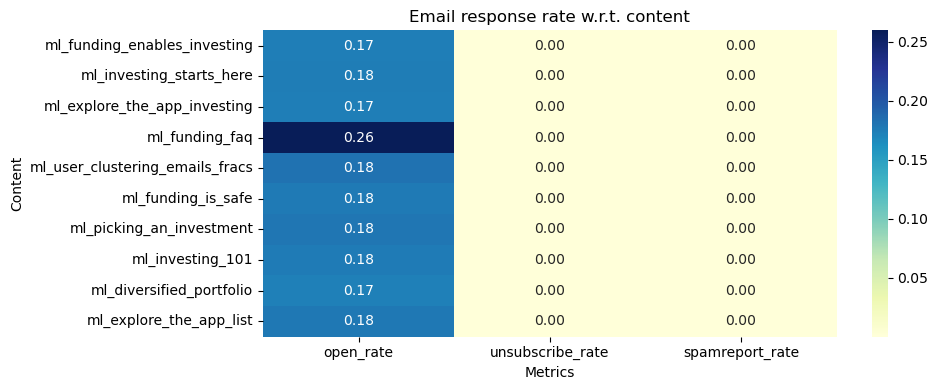

In [15]:
plt.figure(figsize=(10,4))
sns.heatmap(res[['open_rate', 'unsubscribe_rate', 'spamreport_rate']], annot=True, fmt=".2f", cmap="YlGnBu")

plt.title('Email response rate w.r.t. content')
plt.xlabel('Metrics')
plt.ylabel('Content')
plt.tight_layout()
plt.show()

We observed that the **ml_funding_faq** email has a significantly higher open rate compared to other email variants, suggesting it has the strongest user responses. In contrast, unsubscribe and spam report rates remain relatively consistent across all email titles, indicating that no specific message is triggering concerning reactions. This pattern may imply that unfunded users are actively seeking more information about the funding process. Providing additional FAQ content or educational resources related to funding could be a promising strategy to further improve user conversion and overall funding rates.

Next we examine the opening rate (i.e. response rate) across different treatment groups.

In [17]:
df4_estatus = df4[['group_name']+df4_cols].copy().set_index('group_name')
df4_estatus.head()

,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list
group_name,,,,,,,,,,
ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,open,delivered
ML_unfund_exp_control_D,delivered,delivered,open,open,open,delivered,delivered,delivered,delivered,open
ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered
ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df4_estatus_delivered = df4_estatus.notnull().astype(int)
df4_estatus_delivered_tot = df4_estatus_delivered.groupby(level=0).sum()
df4_estatus_delivered_tot['pooled'] = df4_estatus_delivered_tot.sum(axis=1)
df4_estatus_delivered_tot.head()

,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list,pooled
group_name,,,,,,,,,,,
20D_Act-5D_Act_D,19230,19257,19252,19251,19253,19251,19271,19265,19241,19249,192520
20D_Act-5D_Act_W,17412,17292,17346,17323,17299,17365,17319,17294,17347,17294,173291
20D_Act_D,19062,19040,19054,19055,19060,19050,19056,19050,19052,19042,190521
20D_Act_W,17202,17132,17148,17107,17052,17156,17108,17097,17156,17094,171252
6M_App-20D_Act-5D_Act_D,19290,19285,19268,19289,19283,19285,19270,19282,19308,19273,192833


In [19]:
df4_estatus_opened = df4_estatus.map(lambda x: 1 if x == 'open' else 0)
df4_estatus_opened_tot = df4_estatus_opened.groupby(level=0).sum()
df4_estatus_opened_tot['pooled'] = df4_estatus_opened_tot.sum(axis=1)
df4_estatus_opened_tot.head()

,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list,pooled
group_name,,,,,,,,,,,
20D_Act-5D_Act_D,3191,3140,3171,5054,3407,3215,3306,3243,3043,3290,34060
20D_Act-5D_Act_W,2873,2875,2843,4545,3117,2878,2924,2869,2829,2879,30632
20D_Act_D,3464,3455,3487,5108,3650,3501,3545,3476,3524,3520,36730
20D_Act_W,3022,3094,3058,4598,3146,3134,3084,3113,3010,3170,32429
6M_App-20D_Act-5D_Act_D,3465,3493,3423,4896,3698,3486,3644,3520,3430,3590,36645


In [20]:
res_group_open_rate = df4_estatus_opened_tot/df4_estatus_delivered_tot
res_group_open_rate.head()

,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list,pooled
group_name,,,,,,,,,,,
20D_Act-5D_Act_D,0.165939,0.163058,0.164710,0.262532,0.176959,0.167004,0.171553,0.168336,0.158152,0.170918,0.176917
20D_Act-5D_Act_W,0.165001,0.166262,0.163899,0.262368,0.180184,0.165736,0.168832,0.165896,0.163083,0.166474,0.176766
20D_Act_D,0.181723,0.181460,0.183006,0.268066,0.191501,0.183780,0.186031,0.182467,0.184967,0.184855,0.192787
20D_Act_W,0.175677,0.180598,0.178330,0.268779,0.184494,0.182677,0.180267,0.182079,0.175449,0.185445,0.189364
6M_App-20D_Act-5D_Act_D,0.179627,0.181125,0.177652,0.253823,0.191775,0.180762,0.189102,0.182554,0.177647,0.186271,0.190035


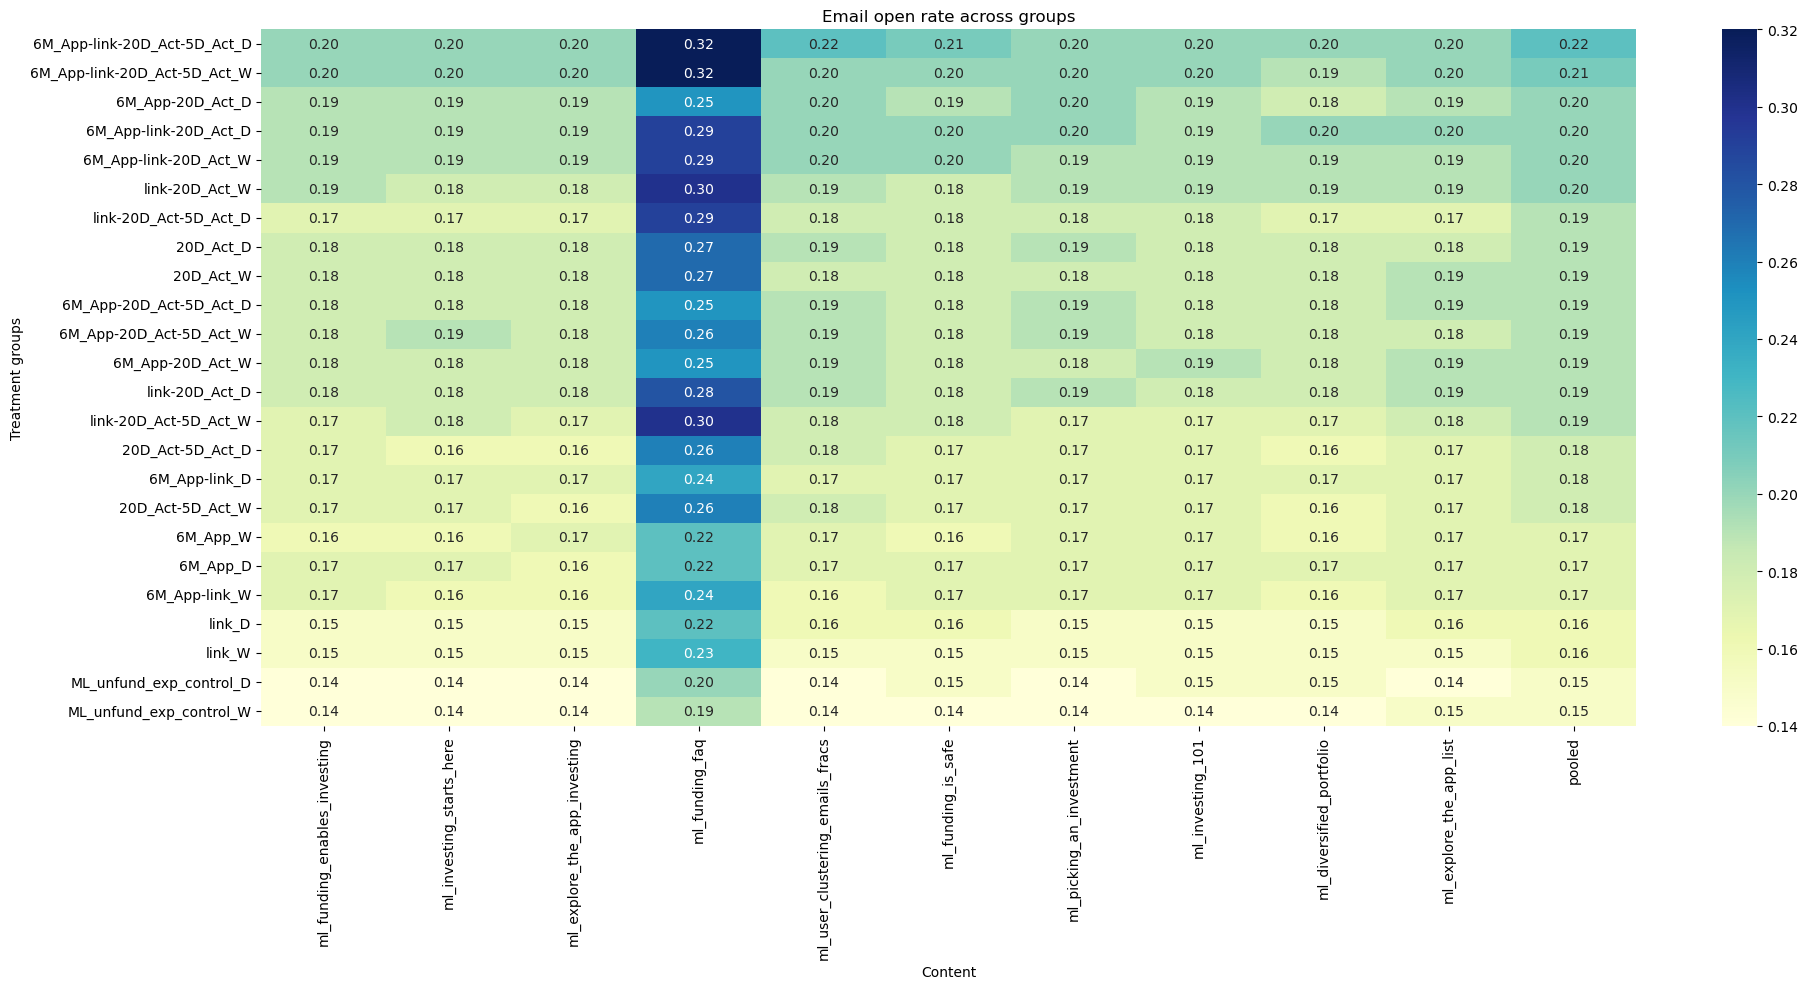

In [21]:
plt.figure(figsize=(20, 10))
sns.heatmap(res_group_open_rate.round(2).sort_values(by=['pooled'], ascending=[0]), annot=True, fmt=".2f", cmap="YlGnBu")

plt.title('Email open rate across groups')
plt.xlabel('Content')
plt.ylabel('Treatment groups')
plt.tight_layout()
plt.show()

In [22]:
res_group_rate_flag = res_group_open_rate.reset_index()[['group_name','pooled']].copy()
res_group_rate_flag['group'] = res_group_rate_flag['group_name'].apply(lambda x: x[:-2]) # aggregate to remove frequency effect
res_group_rate_flag = res_group_rate_flag.groupby("group")['pooled'].mean() # taking easy approach to calculate the average open rate
df1_rate = df1.merge(res_group_rate_flag, how = 'left', left_on='group_name',right_on='group') # link to flags
df1_rate.head()

,Unnamed: 0,group_id,approved_within6M_flag,link_flag,recent_activity_flag(20days),5day_trade_flag,user_uuid,group_name,pooled
0,0,0,False,False,False,False,4418550,ML_unfund_exp_control,0.148848
1,1,1,False,False,True,False,314921,20D_Act,0.191076
2,2,2,False,False,True,True,409786,20D_Act-5D_Act,0.176841
3,3,3,False,True,False,False,941341,link,0.159816
4,4,4,False,True,True,False,102541,link-20D_Act,0.195659


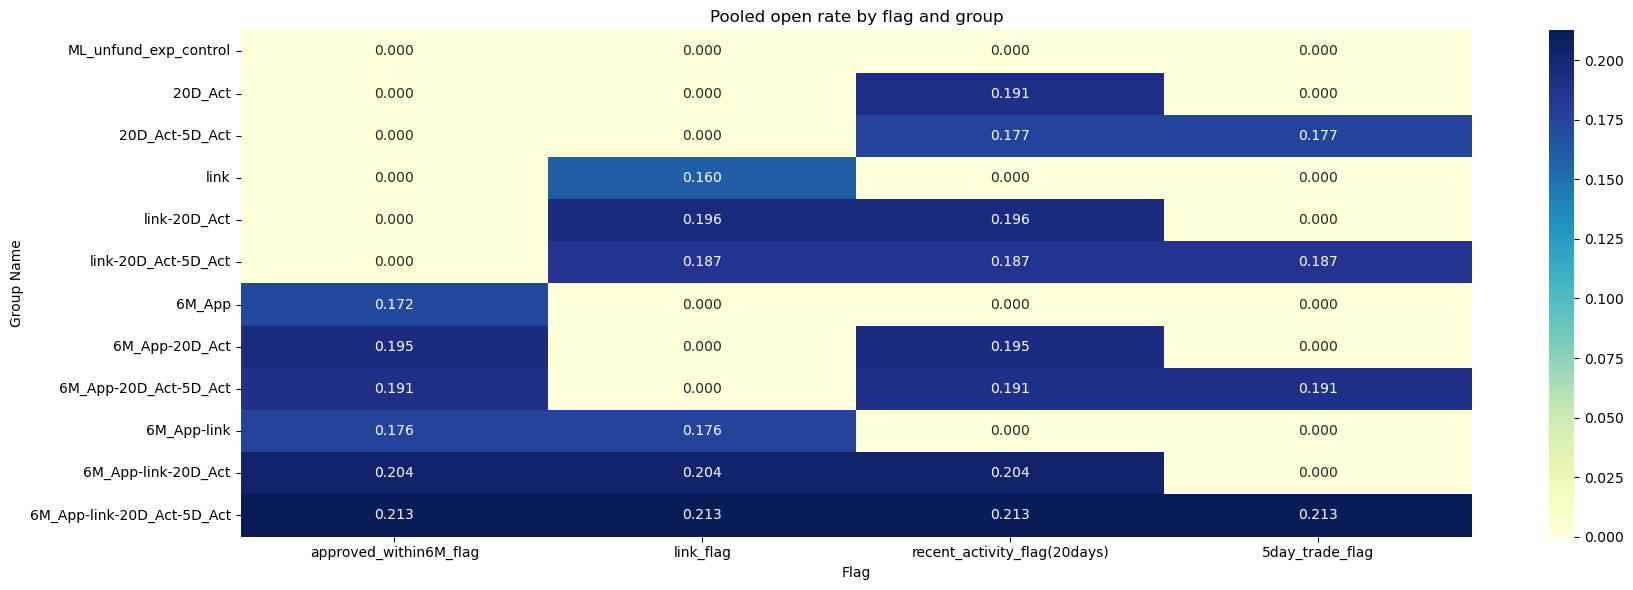

In [23]:
# create visuals
flag_cols = ['approved_within6M_flag', 'link_flag', 'recent_activity_flag(20days)', '5day_trade_flag']

# Multiply each flag by the pooled rate
weighted_flags = df1_rate[flag_cols].astype(int).multiply(df1_rate['pooled'], axis=0)

# Set group_name as index (optional, for clearer labels)
weighted_flags.index = df1_rate['group_name']

# Create the heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(weighted_flags, annot=True, cmap='YlGnBu', fmt=".3f")
plt.title('Pooled open rate by flag and group')
plt.xlabel('Flag')
plt.ylabel('Group Name')
plt.tight_layout()
plt.show()

Overall, users with higher levels of activity — specifically those with **recent trading activity within 5 days** or general **account activity within 20 days** — tend to have higher email open rates. While other attributes, such as the **link_flag** and **approved_within6M_flag**, appear to have a less pronounced effect, they still contribute positively to the open rate.

We now examine the impact of email frequency on friction factors, such as spam reports and unsubscribes.

In [25]:
df4['freq'] = df4['group_name'].apply(lambda x: x[-1])
df4.head()

,user_uuid,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,...,first_funded_at,first_linked_bank_account_at,5d_trading_avg_event_count,2d_non_trading_avg_event_count,20d_trading_avg_event_count,8d_non_trading_avg_event_count,1d_trading_avg_event_count,1d_non_trading_avg_event_count,num_received_email,freq
0,id_2623238174270264636,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,D
1,id_14752263936159847779,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,D
2,id_3723259155072282145,ML_unfund_exp_control_D,delivered,delivered,open,open,open,delivered,delivered,delivered,...,2020-12-04 20:41:55.146,2020-12-04 20:41:37.842,53.0,NaN,171.0,NaN,NaN,NaN,6,D
3,id_9433964625840258739,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,D
4,id_17251718038176858460,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,D


In [26]:
fric = df4[["freq"]].copy()

for col in df4_cols:    
    fric[col] = df4[col].apply(lambda x: 1 if x in ['unsubscribe', 'spamreport'] else 0)

frec_group = fric.groupby("freq")[df4_cols].mean()
frec_group['pooled'] = frec_group.mean(axis=1)
frec_group['pooled']

freq
D    0.000325
W    0.000217
Name: pooled, dtype: float64

We observed that sending emails daily slightly increased the likelihood of users unsubscribing or reporting the email as spam. While a formal statistical test could be conducted to assess the significance of this finding, given the large size of the dataset, it is highly probable that the results would be statistically significant. Additionally, this outcome aligns with intuition, as frequent daily emails are more likely to cause user fatigue and lead to higher friction in terms of unsubscribes or spam reports.

# 2. Linking & funding rate

In [29]:
groups = df4[["group_name","first_funded_at","first_linked_bank_account_at"]].copy()
groups.head()

,group_name,first_funded_at,first_linked_bank_account_at
0,ML_unfund_exp_control_D,NaN,NaN
1,ML_unfund_exp_control_D,NaN,NaN
2,ML_unfund_exp_control_D,2020-12-04 20:41:55.146,2020-12-04 20:41:37.842
3,ML_unfund_exp_control_D,NaN,NaN
4,ML_unfund_exp_control_D,NaN,NaN


In [30]:
groups['funded?'] = groups['first_funded_at'].apply(lambda x: 1 if pd.notna(x) else 0)
groups['linked?'] = groups['first_linked_bank_account_at'].apply(lambda x: 1 if pd.notna(x) else 0)
groups.head()

,group_name,first_funded_at,first_linked_bank_account_at,funded?,linked?
0,ML_unfund_exp_control_D,NaN,NaN,0,0
1,ML_unfund_exp_control_D,NaN,NaN,0,0
2,ML_unfund_exp_control_D,2020-12-04 20:41:55.146,2020-12-04 20:41:37.842,1,1
3,ML_unfund_exp_control_D,NaN,NaN,0,0
4,ML_unfund_exp_control_D,NaN,NaN,0,0


In [31]:
res1 = groups.groupby("group_name")[["funded?", "linked?"]].sum()
res1 = res1.sort_values(by=["funded?", "linked?"], ascending=[0, 0])
res1['delivered_count'] = df4_estatus_delivered_tot.loc[res1.index, 'pooled']

df4_estatus_delivered_tot1 = df4_estatus_delivered_tot.copy()
df4_estatus_delivered_tot1['total'] = df4_estatus_delivered_tot1.iloc[:,:-1].max(axis=1)
res1['num_users_in_treatment'] = df4_estatus_delivered_tot1.loc[res1.index, 'total']

res1['fund_rate'] = res1['funded?']/res1['num_users_in_treatment']
res1['link_rate'] = res1['linked?']/res1['num_users_in_treatment']
res1

,funded?,linked?,delivered_count,num_users_in_treatment,fund_rate,link_rate
group_name,,,,,,
6M_App-link-20D_Act-5D_Act_D,2143,20000,192023,19217,0.111516,1.040745
6M_App-link-20D_Act-5D_Act_W,2114,20000,171941,17251,0.122544,1.159353
6M_App-20D_Act-5D_Act_D,1259,1465,192833,19308,0.065206,0.075875
6M_App-20D_Act-5D_Act_W,1252,1454,173568,17409,0.071917,0.083520
6M_App-link-20D_Act_D,822,20000,189363,18962,0.043350,1.054741
link-20D_Act-5D_Act_D,780,20000,187616,18795,0.041500,1.064113
6M_App-link-20D_Act_W,757,20000,168651,16951,0.044658,1.179871
link-20D_Act-5D_Act_W,749,20000,166168,16685,0.044891,1.198681
6M_App-20D_Act_D,690,792,190451,19065,0.036192,0.041542


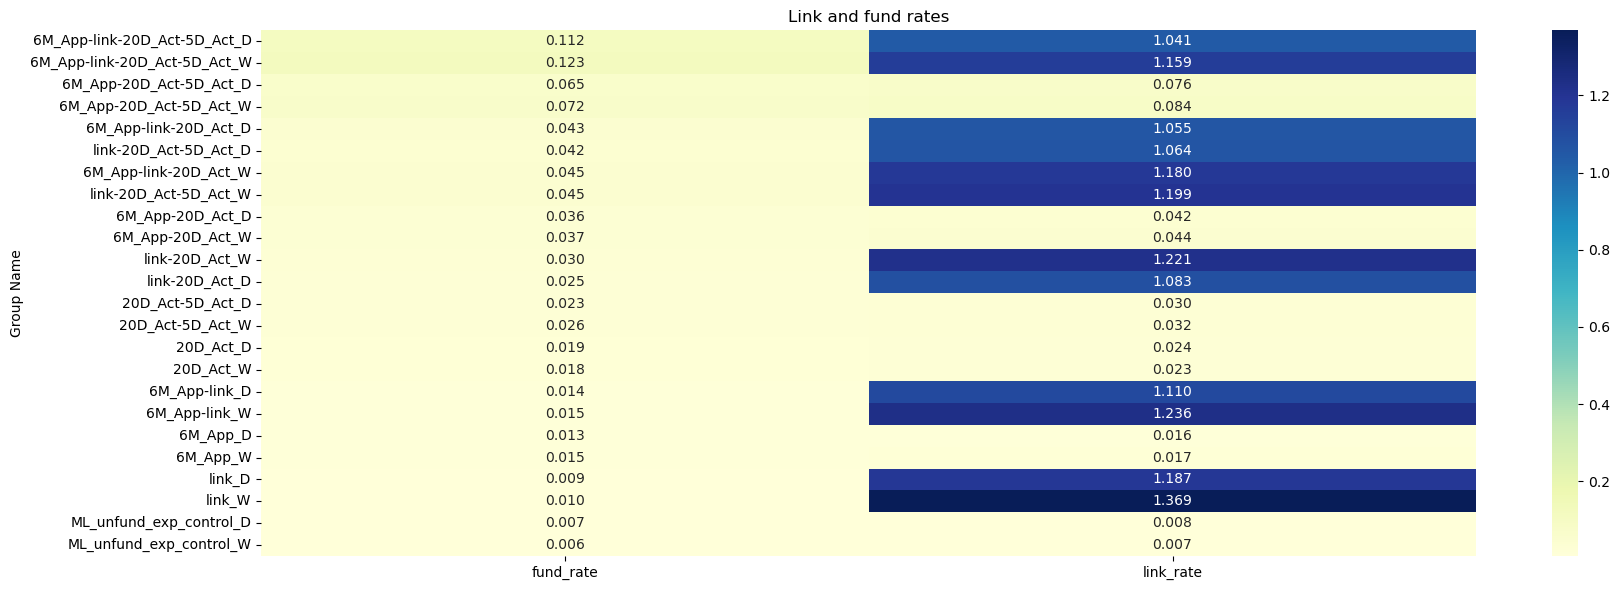

In [32]:
plt.figure(figsize=(18, 6))
sns.heatmap(res1[['fund_rate', 'link_rate']], annot=True, cmap='YlGnBu', fmt=".3f")
plt.title('Link and fund rates')
plt.ylabel('Group Name')
plt.tight_layout()
plt.show()

We observed that the group with the highest funding rate saw an 11% funding rate after receiving the email campaign, compared to just 1% for dormant users. Similarly, the linking rate was about 7% for the previously unfunded users with the highest engagement, while it was only 1% for those with the lowest engagement. However, we did not observe a significant difference in either of these rates based on email frequency, suggesting that the frequency of emails did not play a decisive role in driving these outcomes.

# 3. A/B testing

We want to verify whether sending emails actually improves the funding rate.

\begin{align*}
H_0 &: p_{\text{email}} = p_{\text{no email}} \quad \text{(Sending emails does not affect the funding rate)} \\
H_a &: p_{\text{email}} > p_{\text{no email}} \quad \text{(Sending emails increases the funding rate)}
\end{align*}

\begin{align*}
\hat{p}_1 = \text{funding rate with email} \\
\hat{p}_2 = \text{funding rate without email} \\
\hat{p} = \frac{x_1 + x_2}{n_1 + n_2} \quad \text{(pooled proportion)} \\
Z = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{\hat{p}(1 - \hat{p}) \left(\frac{1}{n_1} + \frac{1}{n_2} \right)}}
\end{align*}

In [35]:
df5 = pd.read_csv('data/control_groups_rate.csv')
df5.head()

,group_name,num_users_in_control,num_funded_in_control,funding_rate_in_control,num_link_in_control,link_rate_in_control
0,20D_Act-5D_Act_D,369786,7802,0.021099,9899,0.026770
1,20D_Act_D,274921,4053,0.014742,5143,0.018707
2,6M_App-20D_Act-5D_Act_D,193445,11556,0.059738,13396,0.069250
3,6M_App-20D_Act_D,178938,5636,0.031497,6570,0.036717
4,6M_App-link-20D_Act-5D_Act_D,29697,3047,0.102603,29697,1.000000


In [36]:
abtesting = df5[['group_name', 'num_users_in_control', 'funding_rate_in_control']].copy()
abtesting = pd.merge(abtesting, res1, on = 'group_name')
abtesting = abtesting.rename(columns={'fund_rate': 'funding_rate_in_treatment'})
abtesting.head()

,group_name,num_users_in_control,funding_rate_in_control,funded?,linked?,delivered_count,num_users_in_treatment,funding_rate_in_treatment,link_rate
0,20D_Act-5D_Act_D,369786,0.021099,451,586,192520,19271,0.023403,0.030408
1,20D_Act_D,274921,0.014742,357,460,190521,19062,0.018728,0.024132
2,6M_App-20D_Act-5D_Act_D,193445,0.059738,1259,1465,192833,19308,0.065206,0.075875
3,6M_App-20D_Act_D,178938,0.031497,690,792,190451,19065,0.036192,0.041542
4,6M_App-link-20D_Act-5D_Act_D,29697,0.102603,2143,20000,192023,19217,0.111516,1.040745


In [37]:
def z_test(row):
    z_stat, p_value = proportions_ztest(
                            count = [row['funding_rate_in_treatment'] * row['num_users_in_treatment'],
                                     row['funding_rate_in_control'] * row['num_users_in_control']],
                            nobs = [row['num_users_in_treatment'], row['num_users_in_control']],
                            alternative='larger')
    return pd.Series({'z_stat': z_stat, 'p_value': p_value})

In [38]:
abtesting['diff'] = abtesting['funding_rate_in_treatment'] - abtesting['funding_rate_in_control']
abtesting[['z_stat', 'p_value']] = abtesting.apply(z_test, axis = 1)
abtesting['reject_null?'] = (abtesting['p_value'] < 0.05).astype(int)
abtesting.sort_values(by=['p_value'])

,group_name,num_users_in_control,funding_rate_in_control,funded?,linked?,delivered_count,num_users_in_treatment,funding_rate_in_treatment,link_rate,diff,z_stat,p_value,reject_null?
8,ML_unfund_exp_control_D,1000000,0.004443,113,136,165796,16615,0.006801,0.008185,0.002358,4.513286,0.000003,1
1,20D_Act_D,274921,0.014742,357,460,190521,19062,0.018728,0.024132,0.003986,4.378064,0.000006,1
11,link_D,901341,0.006386,148,20000,168201,16845,0.008786,1.187296,0.002400,3.861089,0.000056,1
3,6M_App-20D_Act_D,178938,0.031497,690,792,190451,19065,0.036192,0.041542,0.004695,3.504245,0.000229,1
4,6M_App-link-20D_Act-5D_Act_D,29697,0.102603,2143,20000,192023,19217,0.111516,1.040745,0.008913,3.126011,0.000886,1
2,6M_App-20D_Act-5D_Act_D,193445,0.059738,1259,1465,192833,19308,0.065206,0.075875,0.005468,3.045260,0.001162,1
7,6M_App_D,774827,0.011196,240,282,180061,18034,0.013308,0.015637,0.002112,2.659301,0.003915,1
9,link-20D_Act-5D_Act_D,96513,0.037767,780,20000,187616,18795,0.041500,1.064113,0.003733,2.437625,0.007392,1
5,6M_App-link-20D_Act_D,7883,0.036915,822,20000,189363,18962,0.043350,1.054741,0.006435,2.408697,0.008005,1
10,link-20D_Act_D,62541,0.022225,461,20000,184303,18461,0.024972,1.083365,0.002746,2.194065,0.014115,1


We observe that all treatment groups have p-values less than 0.05, indicating statistically significant evidence against the null hypothesis. This suggests that sending daily emails has a measurable and positive effect on the funding rate. In other words, the increase in funding rates among the treatment groups is unlikely to be due to random chance, supporting the conclusion that daily email communication improves user engagement or conversion.

# 4. Time series

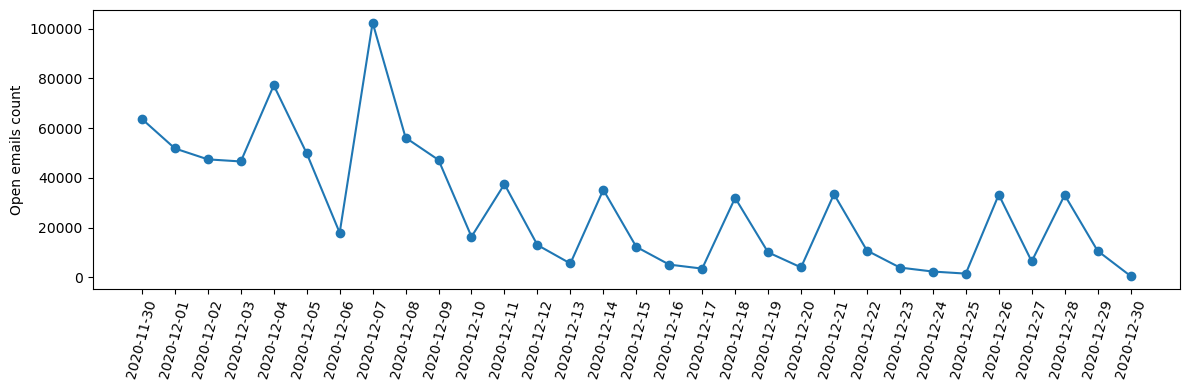

In [41]:
# count the number of emails that are opened
open_emails = df3[df3['event']=='open']
open_emails = open_emails.groupby('stitch_email_events.dt_date')['event'].count()

# visuals
plt.figure(figsize=(12, 4))
plt.plot(open_emails.index, open_emails.values, marker='o', label='Opened Emails', color='tab:blue')
plt.ylabel('Open emails count')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

It appears that users typically do not open emails immediately upon receiving them, but rather take about a week for their engagement behavior to stabilize. Interestingly, there is a noticeable spike in open rates between December 4th and 7th, which warrants further examination to validate the data. Assuming the spike is accurate, it suggests that sending 2–3 emails within the first week may be an effective strategy to maximize open rates. Additionally, the declining trend observed after the first week indicates that the effectiveness of the email campaign diminishes over time, implying that campaigns should ideally be concentrated within a one-week window.

In [43]:
def status(row):
    uid = row['user_uuid']
    orders = row[3:]
    res = [uid]+[df4[df4['user_uuid'] == uid].iloc[0,1]]+[np.nan]*10
    stat_rows = df4[df4['user_uuid'] == uid].iloc[:,2:12]
    for i in range(10):
        res[i+2] = (stat_rows.iloc[0, orders[i]])
    return res

In [44]:
#df_new = df2.apply(status, axis=1, result_type='expand')
#df_new.to_csv('df_status.csv')
df_new = pd.read_csv('df_status.csv')
df_new.head()
#df_new

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11
0,0,id_2623238174270264636,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,id_14752263936159847779,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,open,delivered,delivered
2,2,id_3723259155072282145,ML_unfund_exp_control_D,delivered,delivered,open,delivered,delivered,open,open,open,delivered,delivered
3,3,id_9433964625840258739,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered
4,4,id_17251718038176858460,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
df_new['freq'] = df_new['1'].apply(lambda x: x[-1])

In [46]:
res2_D = report(df_new[df_new['freq']=='D'], [str(i) for i in range (2,12)]).transpose()
res2_D['open_rate'] = res2_D['open']/res2_D.sum(axis=1)
res2_D['date'] = pd.date_range(start="2020-11-30", periods=10)
res2_D['weekday'] = res2_D['date'].dt.day_name()
res2_D.sort_values(['open_rate'], ascending=0)

2,delivered,open,unsubscribe,spamreport,open_rate,date,weekday
3,182495,44454,88,22,0.195782,2020-12-01,Tuesday
4,182302,43842,76,20,0.193785,2020-12-02,Wednesday
6,182317,42295,49,13,0.188251,2020-12-04,Friday
2,185334,42595,99,28,0.186774,2020-11-30,Monday
11,175171,40219,47,14,0.186674,2020-12-09,Wednesday
5,183518,41976,69,15,0.186082,2020-12-03,Thursday
7,177088,40193,48,13,0.184930,2020-12-05,Saturday
9,176492,39898,60,10,0.184320,2020-12-07,Monday
10,176496,39334,43,9,0.182201,2020-12-08,Tuesday
8,180739,36057,49,9,0.166273,2020-12-06,Sunday


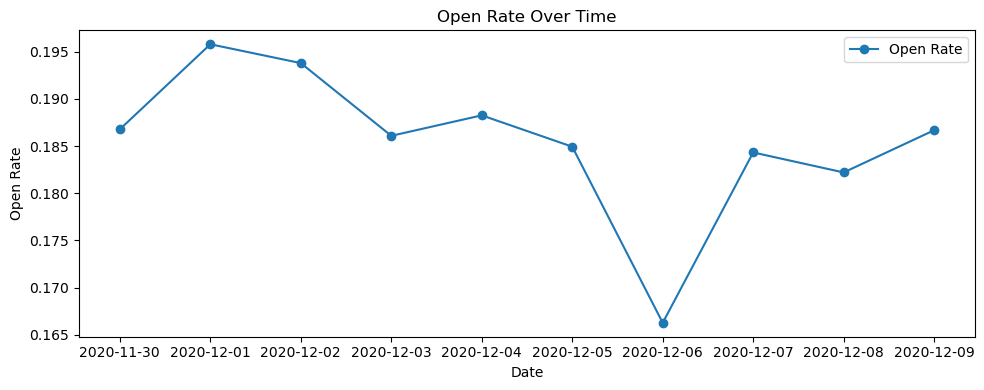

In [47]:
plt.figure(figsize=(10, 4))
plt.plot(res2_D['date'], res2_D['open_rate'], marker='o', label='Open Rate')

plt.title('Open Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Open Rate')
plt.legend()
plt.tight_layout()
plt.show()

Moreover, we observed that the second email in the daily group had the highest open rate. This suggests an opportunity to further optimize the email schedule by placing the most important or high-impact content in the second email. Leveraging this peak in engagement could help maximize visibility and effectiveness of key messages within the campaign timeframe.

In [49]:
res2_W = report(df_new[df_new['freq']=='W'], [str(i) for i in range (2,12)]).transpose()
res2_W['open_rate'] = res2_W['open']/res2_W.sum(axis=1)
res2_W['date'] = pd.date_range(start="2020-11-30", periods=10, freq="4D")
res2_W.sort_values(['open_rate'], ascending=0)

2,delivered,open,unsubscribe,spamreport,open_rate,date
3,181443.0,44803.0,65.0,12.0,0.197960,2020-12-04
4,176248.0,42603.0,61.0,5.0,0.194608,2020-12-08
5,176607.0,41659.0,42.0,6.0,0.190821,2020-12-12
2,184925.0,42962.0,84.0,20.0,0.188437,2020-11-30
6,177738.0,40075.0,47.0,8.0,0.183942,2020-12-16
7,177265.0,39724.0,45.0,5.0,0.183027,2020-12-20
8,177200.0,39368.0,36.0,6.0,0.181746,2020-12-24
9,178400.0,37590.0,30.0,7.0,0.174006,2020-12-28
10,181110.0,34516.0,38.0,5.0,0.160042,2021-01-01
11,2.0,NaN,NaN,NaN,NaN,2021-01-05


We also observed that the final email in the weekly delivery group has not yet received a complete set of engagement data. This indicates that the experiment is still ongoing for this group, as users are likely still in the process of reacting to the most recent email. As such, the current results may not fully reflect the final impact of the campaign. If time allows, it would be beneficial to continue monitoring the activity metrics for this group for at least two more weeks to ensure a more accurate and complete evaluation.

# 5. Funnel analysis

In [52]:
df4['opened?'] = df4[df4_cols].apply(lambda row: 1 if 'open' in row.values else 0, axis=1)
df4.head()

,user_uuid,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,...,first_linked_bank_account_at,5d_trading_avg_event_count,2d_non_trading_avg_event_count,20d_trading_avg_event_count,8d_non_trading_avg_event_count,1d_trading_avg_event_count,1d_non_trading_avg_event_count,num_received_email,freq,opened?
0,id_2623238174270264636,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,D,0
1,id_14752263936159847779,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,D,1
2,id_3723259155072282145,ML_unfund_exp_control_D,delivered,delivered,open,open,open,delivered,delivered,delivered,...,2020-12-04 20:41:37.842,53.0,NaN,171.0,NaN,NaN,NaN,6,D,1
3,id_9433964625840258739,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,D,0
4,id_17251718038176858460,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,D,0


In [53]:
no_link = ["ML_unfund_exp_control_D", '20D_Act_D', "20D_Act-5D_Act_D", "6M_App_D", "6M_App-20D_Act_D","6M_App-20D_Act-5D_Act_D"] + [
            "ML_unfund_exp_control_W", '20D_Act_W', "20D_Act-5D_Act_W", "6M_App_W", "6M_App-20D_Act_W","6M_App-20D_Act-5D_Act_W"]
df4_no_link = df4[df4['group_name'].isin(no_link)]
tot = df4_no_link['user_uuid'].count()
opened = df4_no_link['opened?'].sum()
linked = (df4_no_link['first_linked_bank_account_at']>= '2020-11-30').sum()
funded = (df4_no_link['first_funded_at']>= '2020-11-30').sum()
print('open rate: ', round(opened/tot,4))
print('linked rate: ', round(linked/tot,4))
print('funded rate: ', round(funded/tot,4))

open rate:  0.4958
linked rate:  0.0276
funded rate:  0.0234


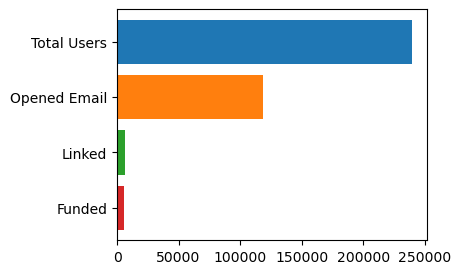

In [54]:
stages = ["Total Users", "Opened Email", "Linked", "Funded"]
values = [tot, opened, linked, funded]  # Example numbers

# Create figure
plt.figure(figsize=(4,3))

# Plot funnel using horizontal bars
plt.barh(stages, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.gca().invert_yaxis()
plt.show()

We noticed that nearly half of the users opened the email, yet the link rate significantly dropped to just 2%, despite a considerable number of users being aware of the emails. However, among the users who did link their bank accounts, the majority went on to fund their accounts. This suggests that while the email open rate is promising, there is a clear opportunity to improve the linking rate. Focusing efforts on increasing the link rate could lead to a substantial increase in overall funding activity, ultimately driving better results for the campaign. We should focus on improving the linking activity for users within the group **6M_App-20D_Act-5D_Act** as the next step.